# Wrapping an existing model
SALib performs sensitivity analysis for any model that can be expressed in the form of `f(X)=Y`,
where `X` is a matrix of inputs (often referred to as the model's factors)

The analysis methods are independent of the model and can be applied non-intrusively such that it does not matter what
`f` is.

Typical model implementations take the form of `f(a, b, c, ...)=Y`. In other words, each model factor is supplied as a separate argument to the function. In such cases it is necessary to write a wrapper to allow use with SALib. This is illustrated here with a simple linear function:

In [1]:
def linear(a, b, x):
    """
    Return y = a + b + x
    """
    return a + b + x

As SALib expects a (numpy) matrix of factors, we simply "wrap" the function above like so:

In [2]:
def wrapped_linear(X, func = linear):
    """g(X) = Y, where X := [a b x] and g(X) := f(X)"""
    # We transpose to obtain each column (the model factors) as separate variables
    a, b, X = X.T
    
    # Then call the original model
    return func(a, b, x)

# Parallel evaluation and analysis
Here we expand on some technical details that enable parallel evaluation and analysis. We noted earlier that
the model being "wrapped" is also passed in as an argument. This is to facilitate parallel evaluation, as the
arguments to the wrapper are passed on to workers. The approach works be using Python's motable default argument
behavior.

A further consideration is that imported modules/packages are not made available to workers in cases where
functions are defined in the same file SALib is used in. Running the previous example with
`.evaluate(wrapped_linear, nprocs=2)` will fail with `NameError: name 'np' is not defined.`

The quick fix is to re-import the required packages within the model function itself:

In [3]:
def wrapped_linear(X: np.ndarray, func=linear) -> np.ndarray:
    import numpy as np  # re-import necessary packages

    N, D = X.shape
    results = np.empty(N)
    for i in range(N):
        a, b, x = X[i, :]
        results[i] = func(a, b, x)

    return results

NameError: name 'np' is not defined

This can, however, get unwieldy for complicated models. The recommended best practice is to separate 
implementation (i.e., model definitions) from its use. Simply moving the model functions into a
separate file is enough for this example, such that the project structure is something like:

project_directory:  
| -- model_definition.py  
|____analyais.py

In [ ]:
import SALib
print(SALib.__version__)

1.4.7


# 重要

In [1]:
# from model_definitions import wrapped_linear
import numpy as np
from SALib import ProblemSpec
import time
import pandas as pd


def wrapped_linear(X):
    import numpy as np
    import time
    N, D = X.shape
    results = np.empty(N)
    for i in range(N):
        # time.sleep(1)
        a, b, x = X[i, :]
        results[i] = a/100 + b*10 * (x/1000)
    return results


if __name__ == "__main__":
    start_time = time.time()  # 记录开始时间
    sp = ProblemSpec({
        'names': ['a', 'b', 'x'],
        'bounds': [
            [-100, 0],
            [-0.1, 0],
            [-1000, 1000],
        ],
    })
    
    (
        sp.sample_sobol(2**8)
        .evaluate(wrapped_linear, nprocs=16)
        .analyze_sobol()
    )
    # print(sp.samples)
    # np.savetxt("samples.txt", sp.samples)
    # print('----')
    # print(sp.results)
    # np.savetxt("results.txt", sp.results)
    # print('----')
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算时间差
    print('计算时间为', elapsed_time, 's')
    print(sp)
    # sp_data = sp.to_df()
    # 打开文件
    # with open('output.txt', 'w') as file:
        # 将列表中的元素逐行写入文件
        # for item in sp_data:
            # file.write(str(item) + '\n')
    # 关闭文件
    # file.close()
    

C:\Users\12734\AppData\Roaming\Python\Python310\site-packages\SALib\util\problem.py:210: UserWarning: Parallel evaluation is an experimental feature and may not work.
  warnings.warn(


计算时间为 1.0906188488006592 s
Samples:
	3 parameters: ['a', 'b', 'x']
	2048 evaluations 

Outputs:
	1 outputs: ['Y']
	2048 evaluations 

Analysis:
         ST   ST_conf
a  0.429249  0.074946
b  0.140061  0.028204
x  0.571214  0.125564 

         S1   S1_conf
a  0.433183  0.104289
b  0.019472  0.072905
x  0.409259  0.108318 

              S2   S2_conf
(a, b) -0.004118  0.159873
(a, x) -0.006559  0.183254
(b, x)  0.123505  0.105094 




In [12]:
# 打开文件
with open('output.txt', 'w') as file:
    # 将列表中的元素逐行写入文件
    for item in sp_data:
        file.write(str(item) + '\n')

# 关闭文件
file.close()

In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
problem = {
    'num_vars': 1,
    'names': ['x1'],
    'bounds': [[4, 0.5]],
    'dists': ['triang']
}

param_values = saltelli.sample(problem, 1024)
param_values

C:\Users\12734\AppData\Local\Temp\ipykernel_18244\800234694.py:10: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


array([[0.10825318],
       [1.73543042],
       [0.10825318],
       ...,
       [2.27359659],
       [0.0625    ],
       [2.27359659]])

<Axes: title={'center': 'Y'}>

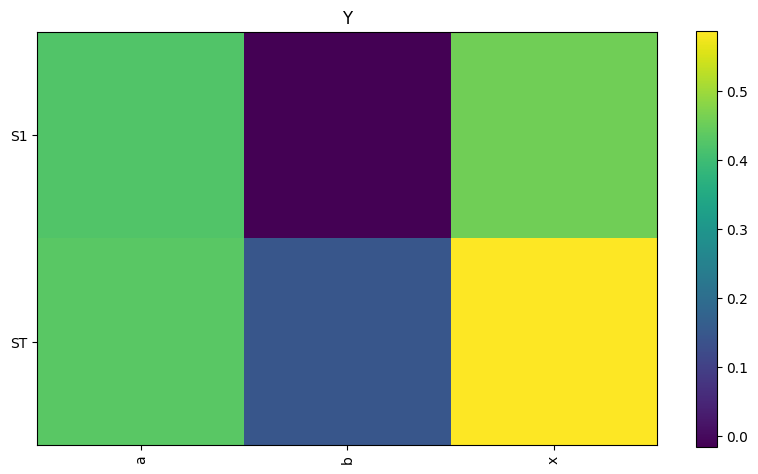

In [2]:
sp.heatmap()